# Torch playground

In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary
from torch.autograd import Variable

from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score, accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder

from tqdm.notebook import tqdm, trange

import matplotlib.pyplot as plt
%matplotlib notebook
plt.style.use('ggplot')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import pickle

from extra.utils import *
from models.loader import *

## Preconfig

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
torch.cuda.is_available()

True

In [4]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

BATCH_SIZE = 128
EPOCHS = 64

# model, model_name, checkpoint_path = ModelLoader(batch_size=BATCH_SIZE, epochs=EPOCHS).load_mobilenetv2()
model, model_name, checkpoint_path = ModelLoader(batch_size=BATCH_SIZE, epochs=EPOCHS).load_mobilenetv3(dropout=0.0)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    model = model.cuda()

In [5]:
model_name, checkpoint_path

('mobilenetv3', './checkpoint/ckpt_mobilenetv3_bs128_ep64.pth')

## CIFAR preload

In [6]:
seed_everything(1337)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Prep

In [7]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001,
#                       momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(model.parameters(), lr=0.0003) #0.01, 0.0003
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [8]:
# summary(model, (3, 32, 32), batch_size=BATCH_SIZE, device='cuda')

## Train

In [ ]:
# Load checkpoint.
print('==> Resuming from checkpoint..')
assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model'])
best_acc = checkpoint['accuracy']
start_epoch = checkpoint['epoch']

In [9]:
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

In [10]:
def train_nn(epoch):
    model.train()
    with tqdm(trainloader, unit='batch') as tepoch:
        for data, target in tepoch:
            tepoch.set_description(f'Train epoch {epoch}')

            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            
            with torch.cuda.amp.autocast():
                output = model(data)
                loss = criterion(output, target)

            _, predictions = output.max(1)
            correct = predictions.eq(target).sum().item()
            accuracy = (predictions == target).float().mean()
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            train_accuracies.append(accuracy.item())
            
            tepoch.set_postfix(loss=loss.item(), accuracy=100. * accuracy.item())

In [11]:
def test_nn(epoch):
    global best_acc
    model.eval()
    with torch.no_grad():
        with tqdm(testloader, unit='batch') as tepoch:
            for data, target in tepoch:
                tepoch.set_description(f'Test epoch {epoch}')
                
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, predictions = output.max(1)
                loss = criterion(output, target)
                correct = predictions.eq(target).sum().item()
                accuracy = (predictions == target).float().mean()
                
                if accuracy > best_acc:
                    state = {
                        'model': model.state_dict(),
                        'accuracy': accuracy,
                        'epoch': epoch,
                    }
                    if not os.path.isdir('checkpoint'):
                        os.mkdir('checkpoint')
                    torch.save(state, checkpoint_path)
                    best_acc = accuracy
                
                test_losses.append(loss.item())
                test_accuracies.append(accuracy.item())
                
                tepoch.set_postfix(loss=loss.item(), accuracy=100. * accuracy.item())     

In [12]:
for epoch in trange(start_epoch, start_epoch+EPOCHS):
    train_nn(epoch)
    test_nn(epoch)
    scheduler.step()

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/391 [00:00<?, ?batch/s]

  0%|          | 0/79 [00:00<?, ?batch/s]

## Save losses and accuracies 

In [13]:
pickle.dump(train_losses, open(f'./storage/{model_name}_train_losses_bs{BATCH_SIZE}_ep{EPOCHS}.pickle', 'wb'))
pickle.dump(train_accuracies, open(f'./storage/{model_name}_train_accuracies_bs{BATCH_SIZE}_ep{EPOCHS}.pickle', 'wb'))
pickle.dump(test_losses, open(f'./storage/{model_name}_test_losses_bs{BATCH_SIZE}_ep{EPOCHS}.pickle', 'wb'))
pickle.dump(test_accuracies, open(f'./storage/{model_name}_test_accuracies_bs{BATCH_SIZE}_ep{EPOCHS}.pickle', 'wb'))

## Load losses and accuracies

In [ ]:
train_losses = unpickle(f'./storage/{model_name}_train_losses_bs{BATCH_SIZE}_ep{EPOCHS}.pickle')
train_accuracies = unpickle(f'./storage/{model_name}_train_accuracies_bs{BATCH_SIZE}_ep{EPOCHS}.pickle')
test_losses = unpickle(f'./storage/{model_name}_test_losses_bs{BATCH_SIZE}_ep{EPOCHS}.pickle')
test_accuracies = unpickle(f'./storage/{model_name}_test_accuracies_bs{BATCH_SIZE}_ep{EPOCHS}.pickle')

<IPython.core.display.Javascript object>


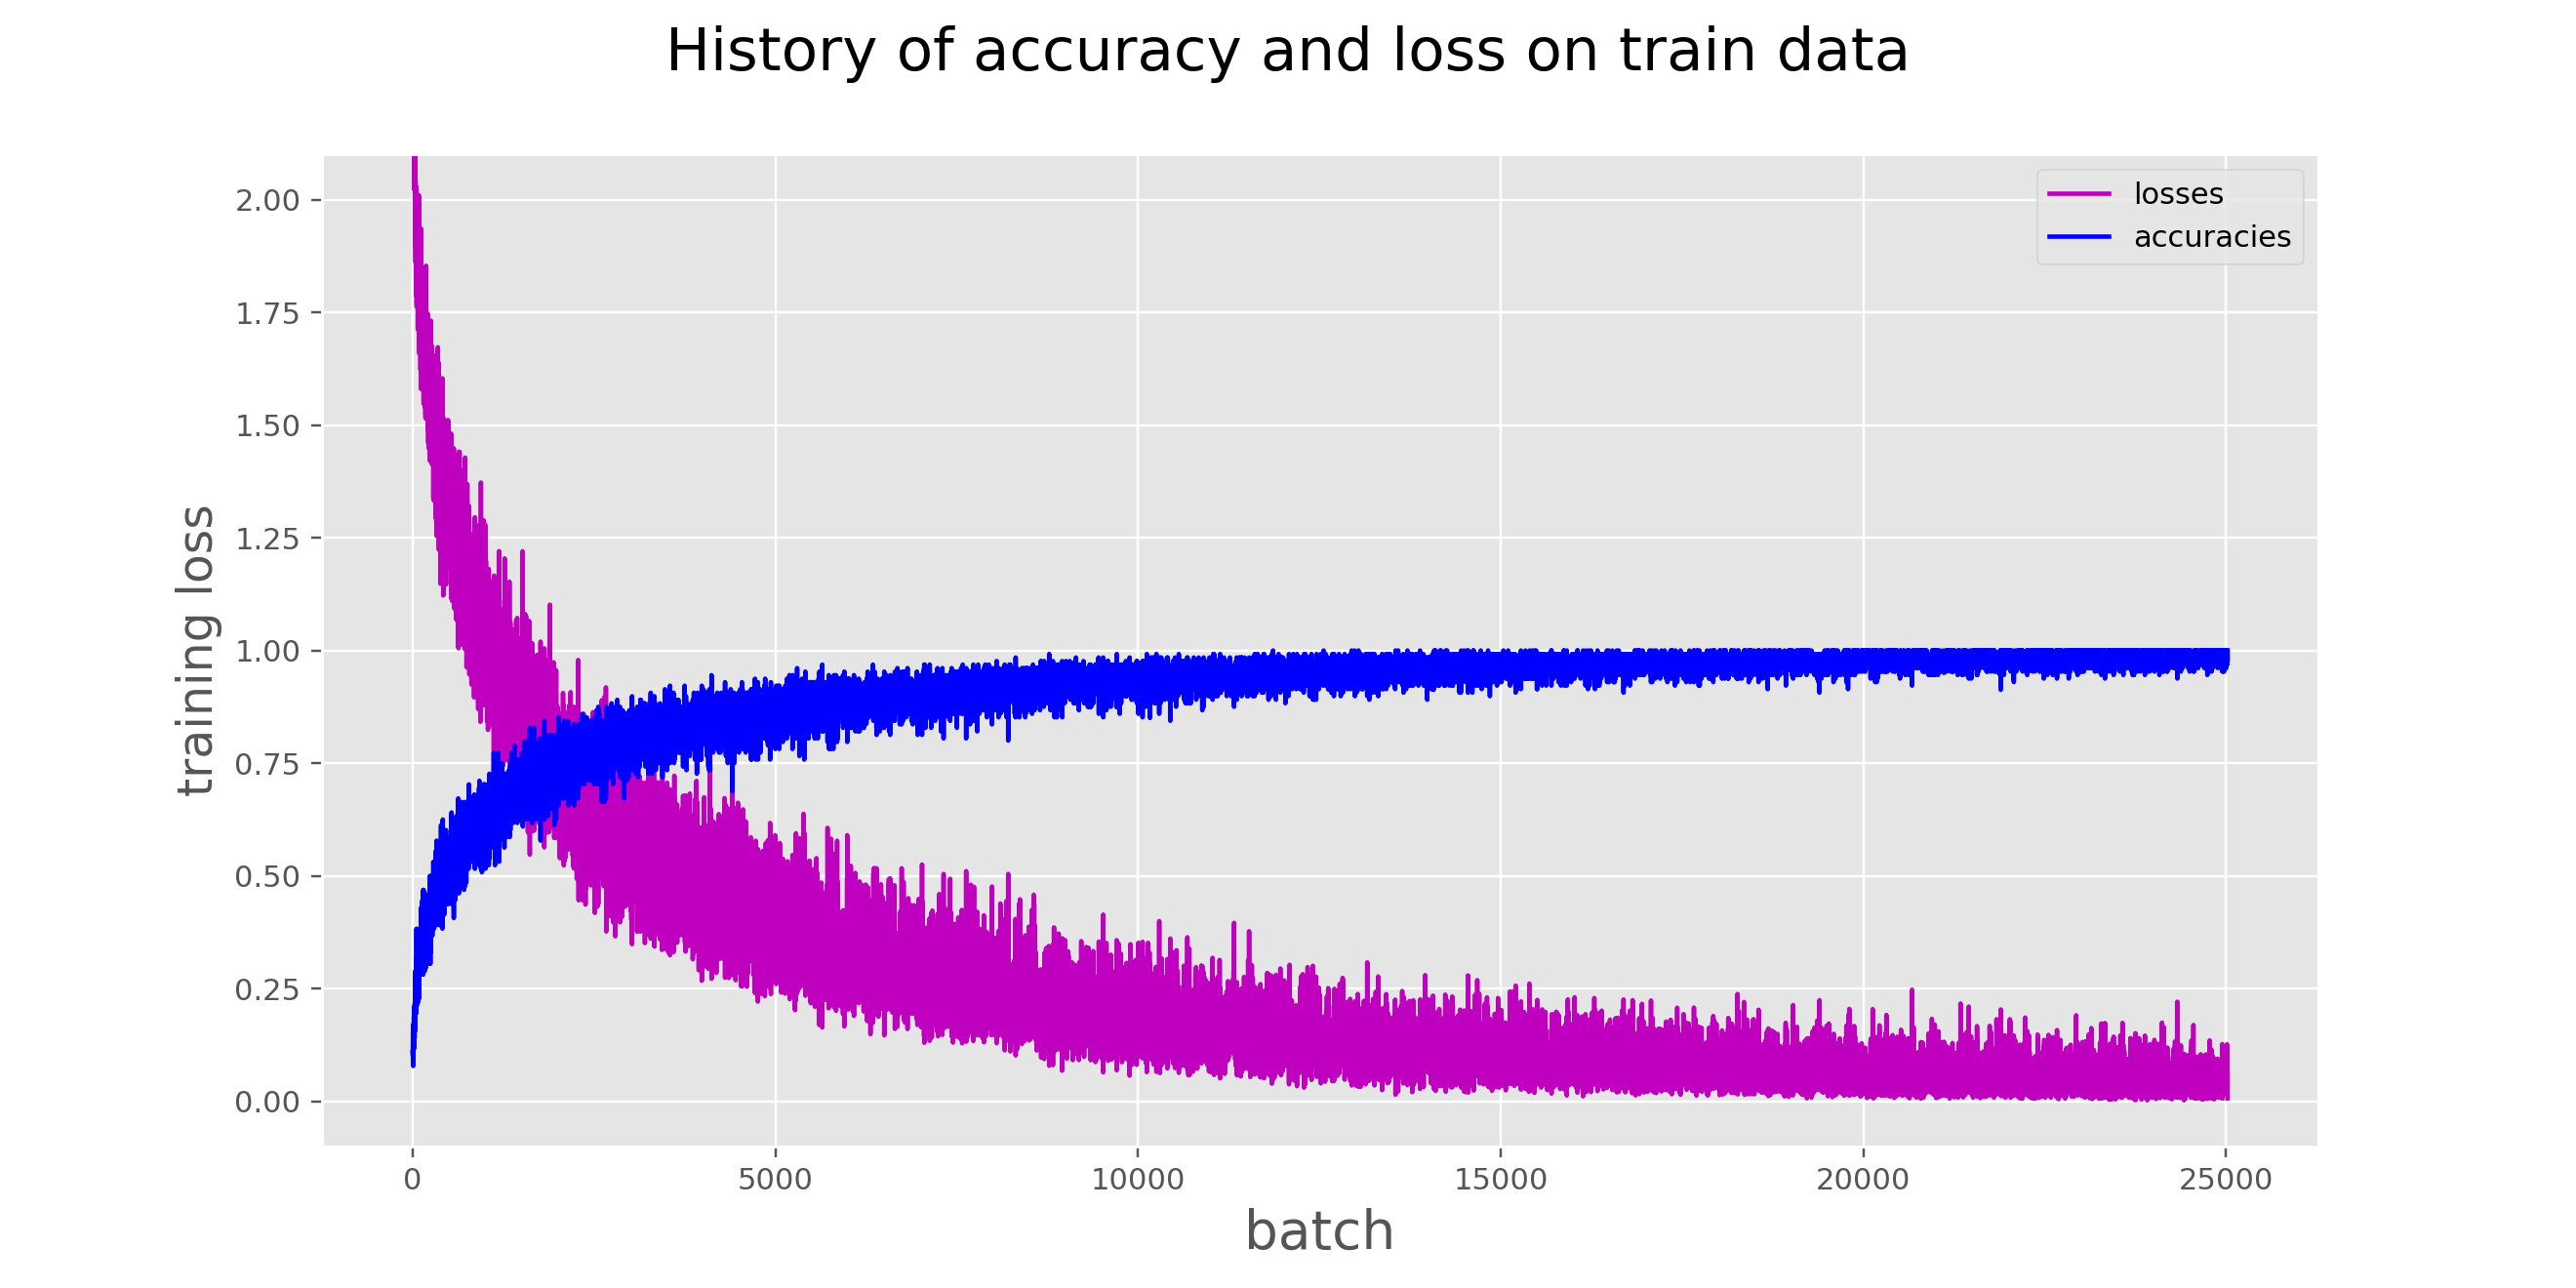

In [14]:
x = np.linspace(0, 15, num=15)

fig = plt.figure(figsize=(12, 6))
plt.plot(train_losses, color='m', label='losses')
plt.plot(train_accuracies, color='b', label='accuracies') 
plt.ylim(-0.1, 2.1)

fig.suptitle('History of accuracy and loss on train data', fontsize=20)
plt.xlabel('batch', fontsize=18)
plt.ylabel('training loss', fontsize=16)
plt.legend(loc='upper right')

plt.show()

<IPython.core.display.Javascript object>


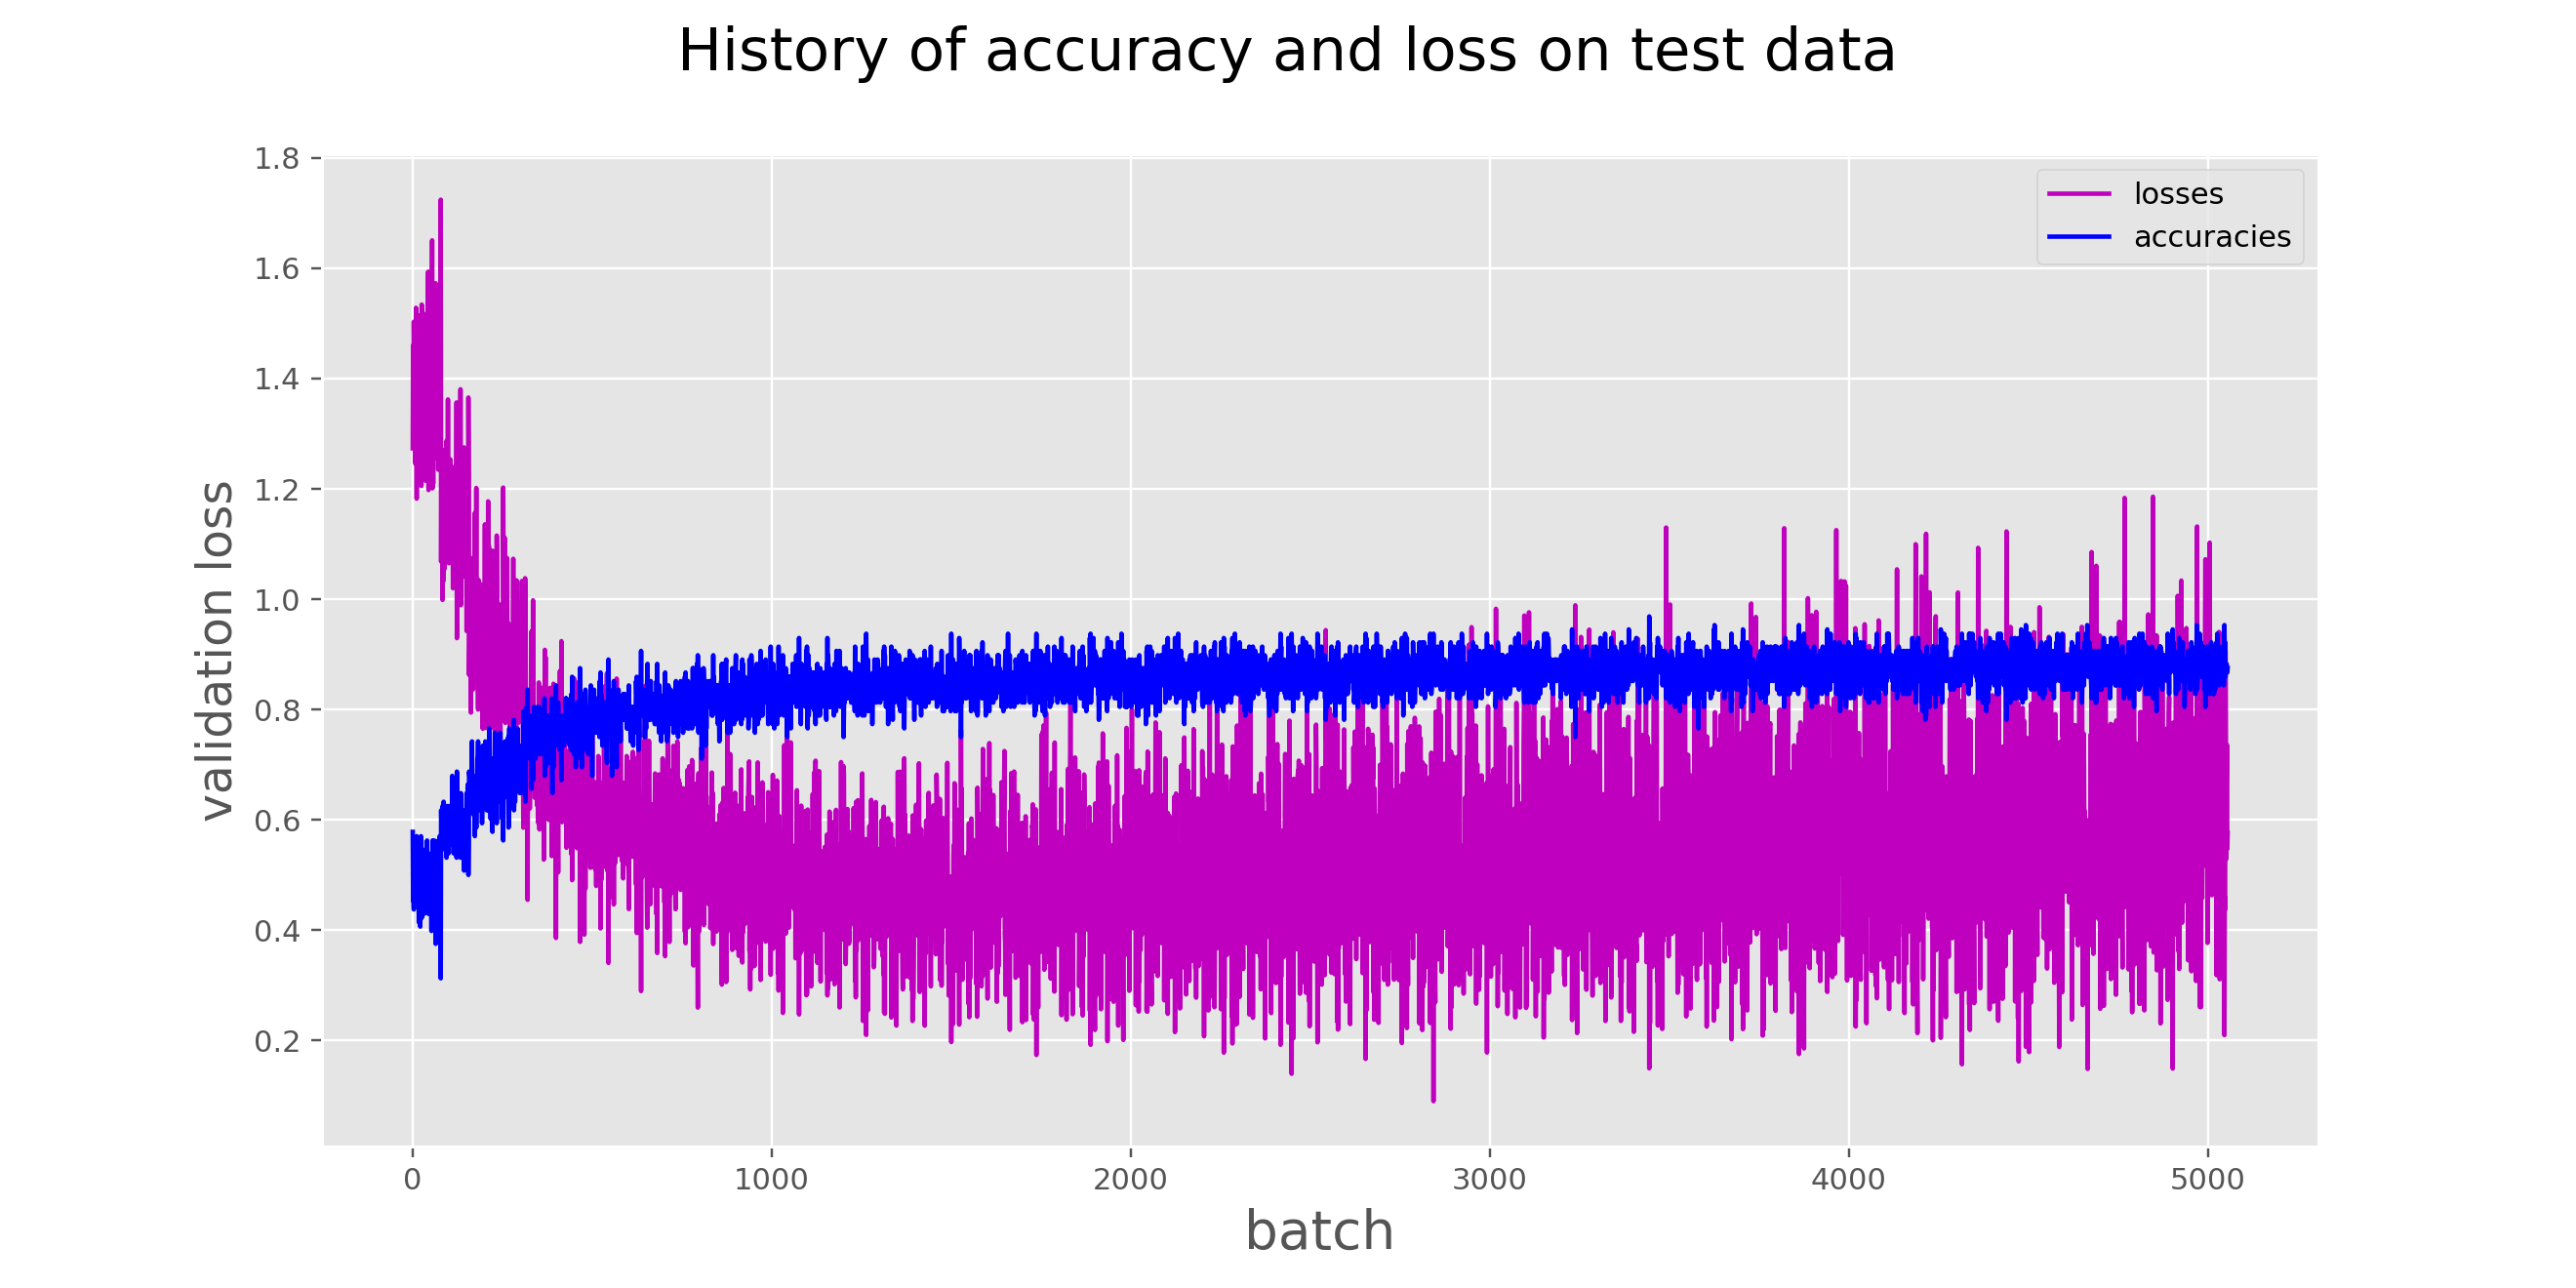

In [15]:
x = np.linspace(0, 15, num=15)

fig = plt.figure(figsize=(12, 6))
plt.plot(test_losses, color='m', label='losses')
plt.plot(test_accuracies, color='b', label='accuracies') 

fig.suptitle('History of accuracy and loss on test data', fontsize=20)
plt.xlabel('batch', fontsize=18)
plt.ylabel('validation loss', fontsize=16)
plt.legend(loc='upper right')

plt.show()

<IPython.core.display.Javascript object>


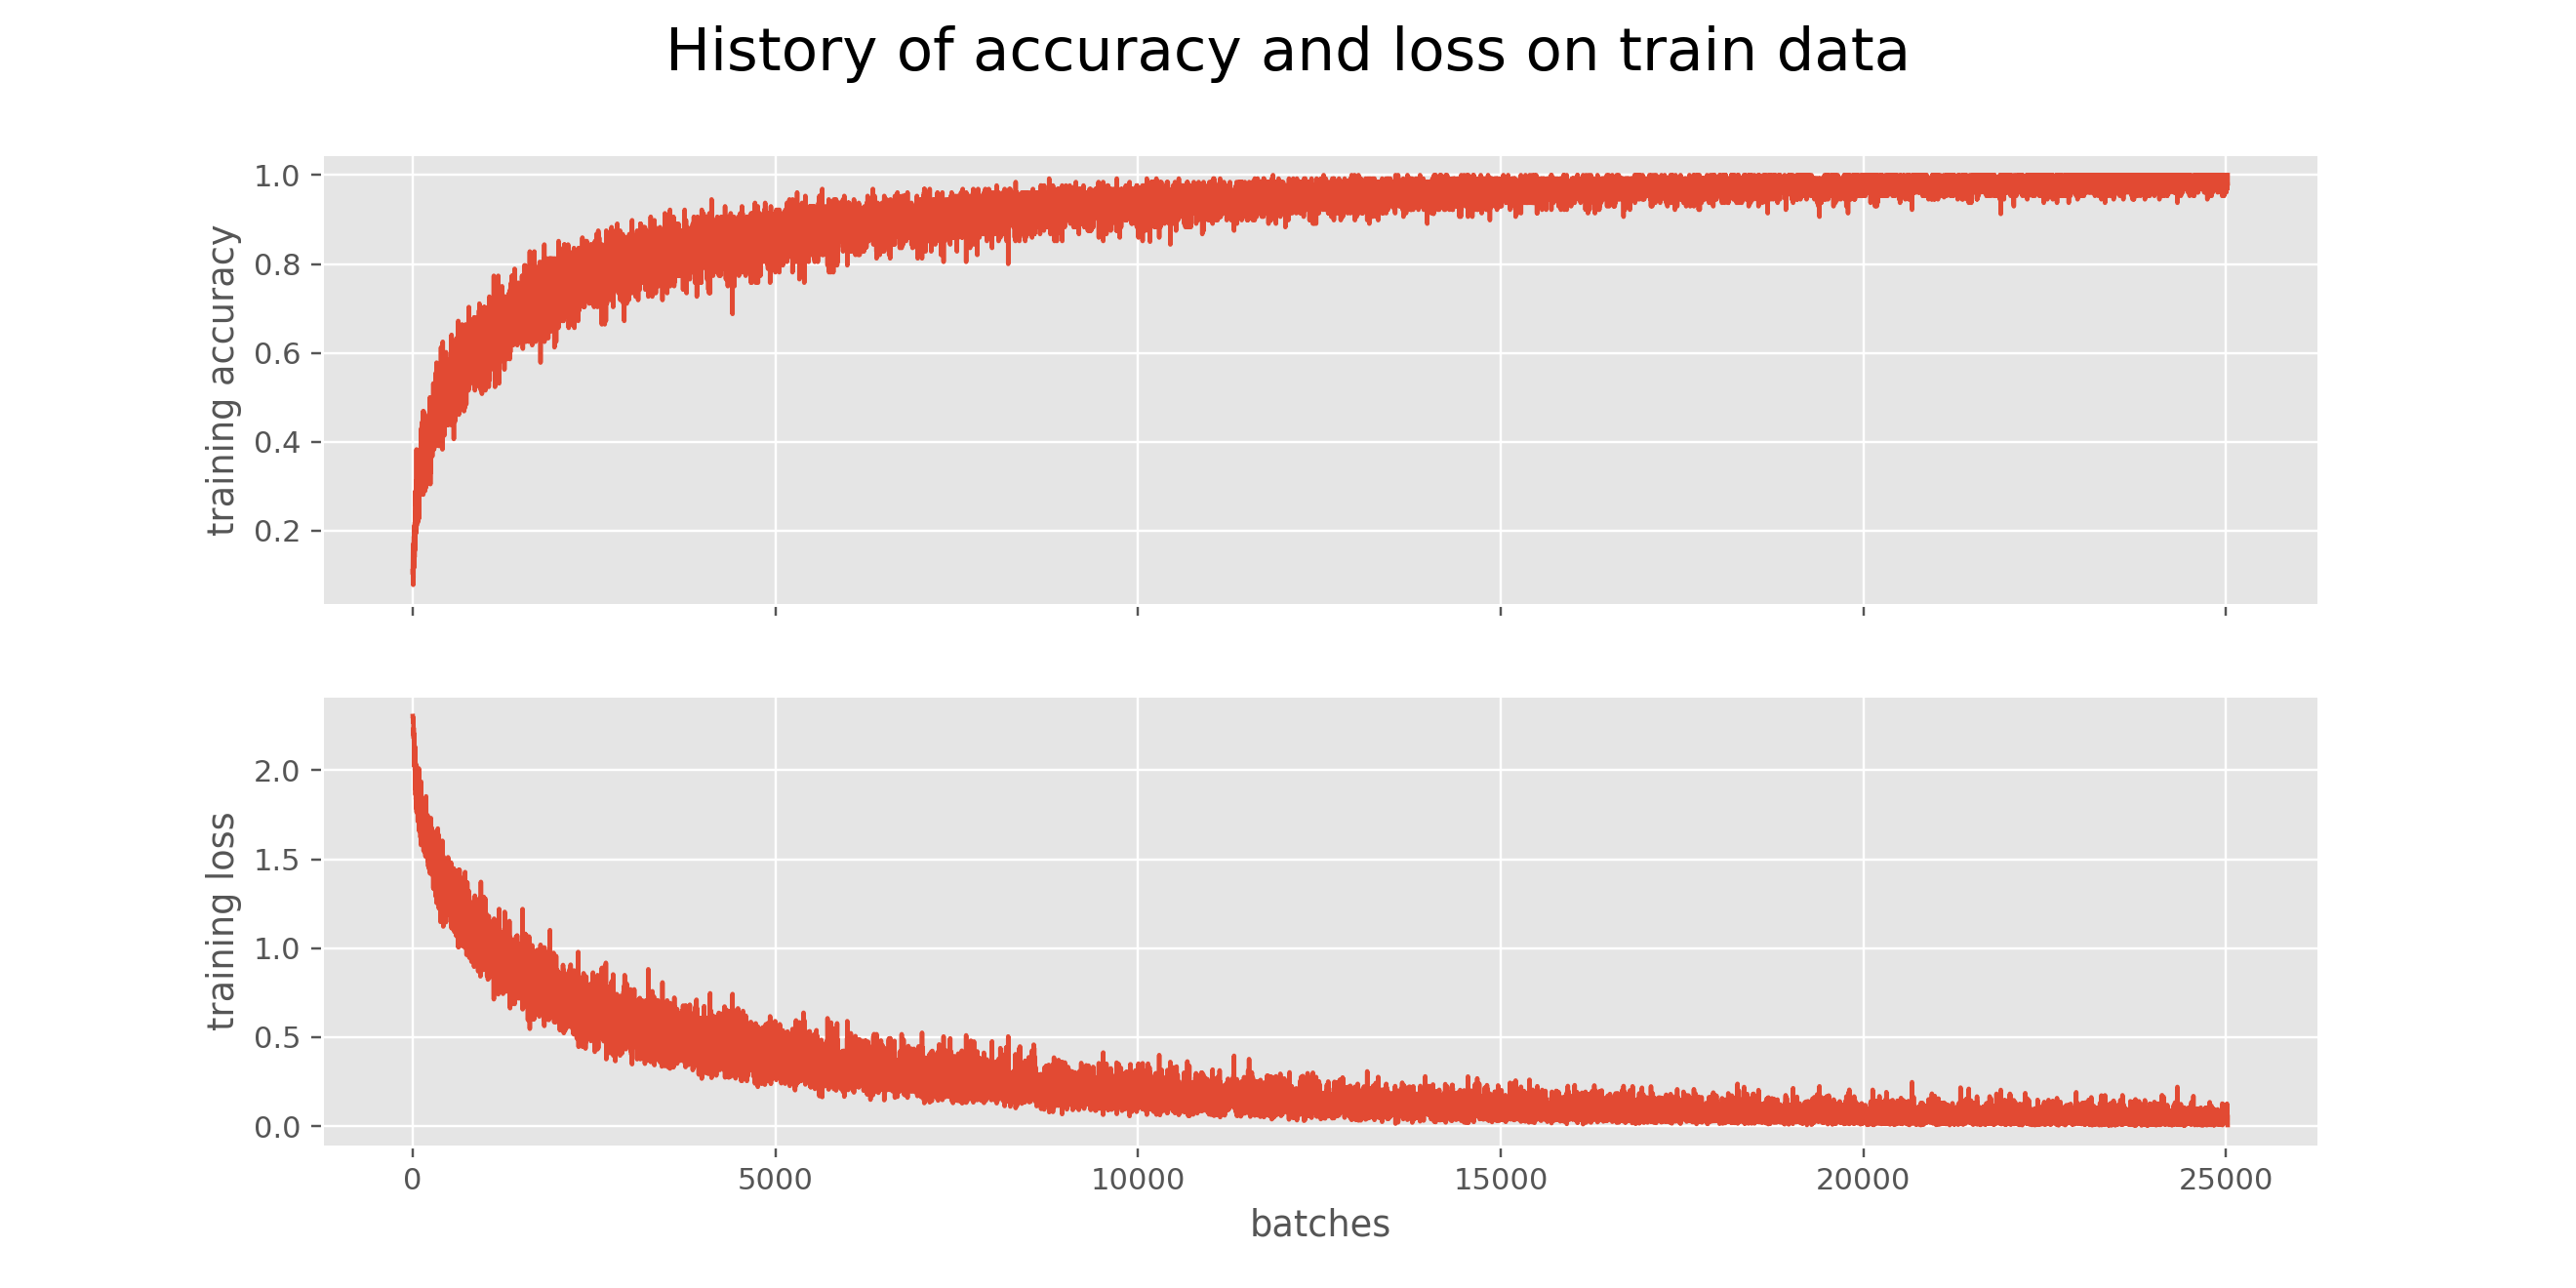

In [16]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
fig.suptitle('History of accuracy and loss on train data', fontsize=20)
ax1.plot(train_accuracies)
ax1.set_ylabel("training accuracy")
ax2.plot(train_losses)
ax2.set_ylabel("training loss")
ax2.set_xlabel("batches");
plt.show()


<IPython.core.display.Javascript object>


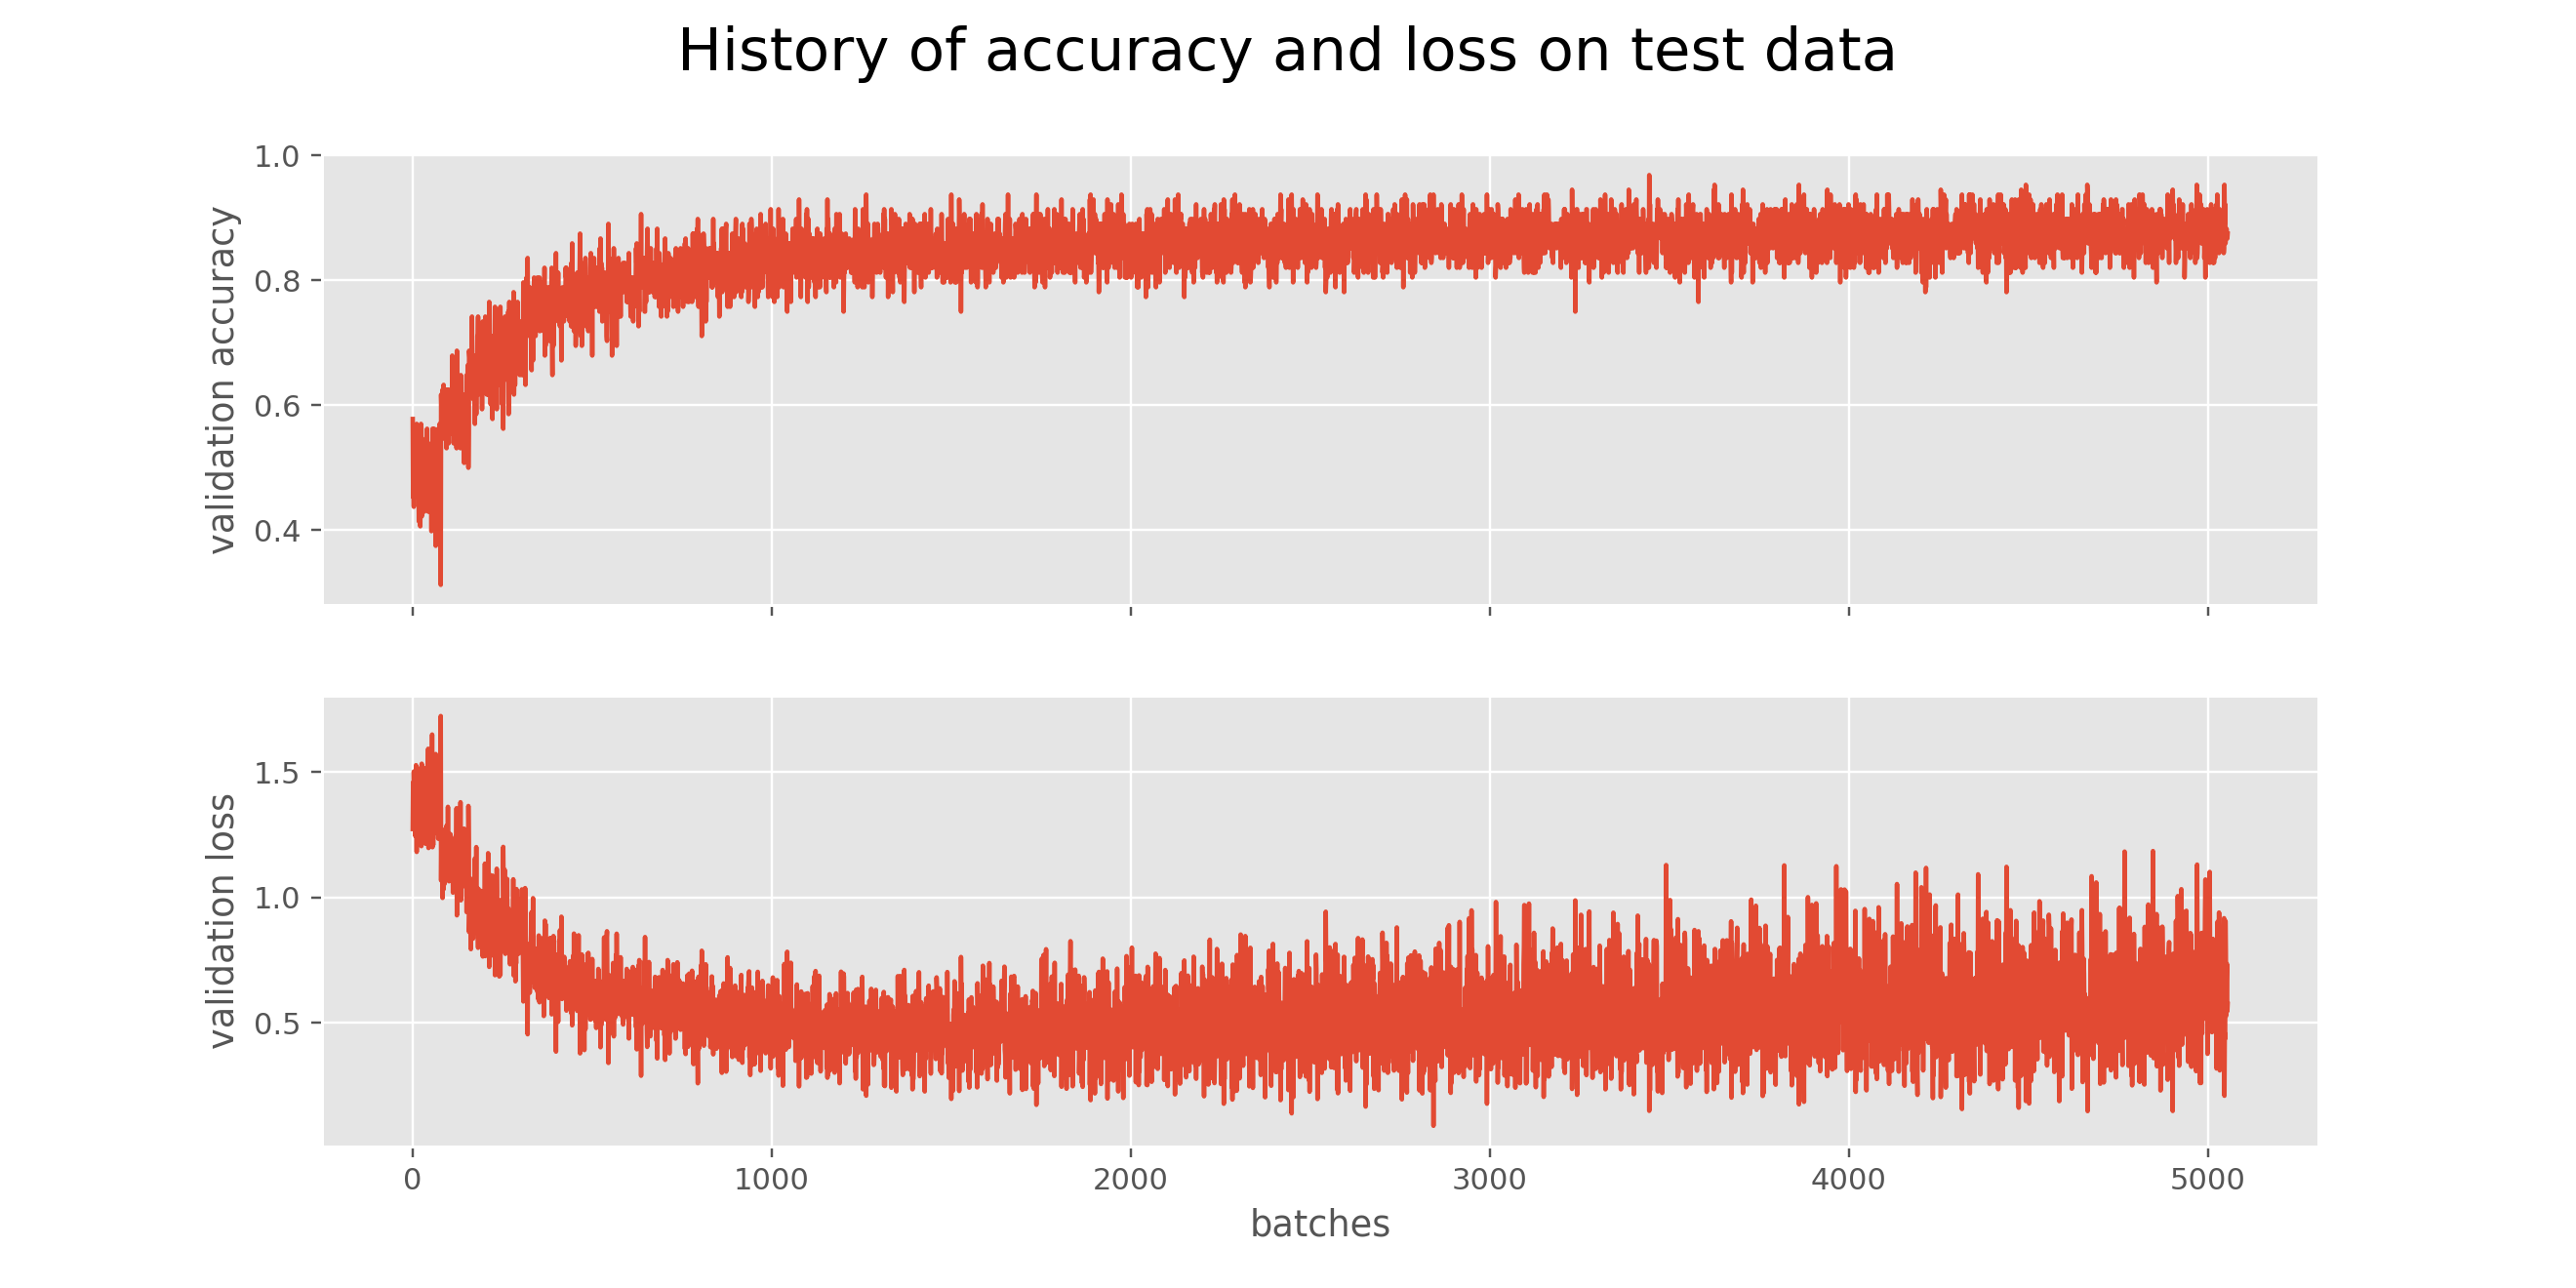

In [17]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
fig.suptitle('History of accuracy and loss on test data', fontsize=20)
ax1.plot(test_accuracies)
ax1.set_ylabel("validation accuracy")
ax2.plot(test_losses)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("batches");


## Metrics

### Confusion matrix, F1 score, accuracy score

In [18]:
def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(model, device, testloader)
print('Confusion matrix:')
print(confusion_matrix(actuals, predictions, normalize='all'))
print('F1 score: %f' % f1_score(actuals, predictions, average='micro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))
# MNv3, 12 ep
# F1 score: 0.826400
# Accuracy score: 0.826400

# MNv2, 12 ep
# F1 score: 0.825600
# Accuracy score: 0.825600

Confusion matrix:
[[0.0905 0.0009 0.0006 0.0012 0.0012 0.0001 0.0004 0.0003 0.0036 0.0012]
 [0.0009 0.0958 0.     0.0001 0.     0.     0.0005 0.     0.0008 0.0019]
 [0.0039 0.     0.0828 0.003  0.0049 0.0016 0.0024 0.0006 0.0005 0.0003]
 [0.0017 0.0003 0.0043 0.0753 0.0048 0.0089 0.0023 0.0011 0.0009 0.0004]
 [0.0004 0.0002 0.0022 0.002  0.0907 0.0008 0.0013 0.002  0.0003 0.0001]
 [0.0007 0.0003 0.0028 0.0114 0.0031 0.0781 0.001  0.0021 0.0003 0.0002]
 [0.0005 0.     0.0022 0.0037 0.0014 0.0008 0.0906 0.0001 0.0005 0.0002]
 [0.001  0.     0.001  0.003  0.0035 0.002  0.0006 0.0883 0.0003 0.0003]
 [0.0022 0.0007 0.0002 0.0004 0.0001 0.     0.0004 0.     0.0957 0.0003]
 [0.0015 0.0034 0.0002 0.0003 0.     0.0001 0.0003 0.0003 0.0017 0.0922]]
F1 score: 0.880000
Accuracy score: 0.880000


### ROC curve

In [ ]:
def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        with tqdm(test_loader, unit='batch') as tepoch:
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                output = model(data)            
                prediction = output.argmax(dim=1, keepdim=True)
                actuals.extend(target.view_as(prediction) == which_class)
                probabilities.extend(torch.exp(output[:, which_class]))

    return [i.item() for i in actuals], [i.item() for i in probabilities]

which_class = classes.index("deer")
actuals, class_probabilities = test_class_probabilities(model, device, testloader, which_class)

fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
# plt.figure()
lw = 2

fig = plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC for label={classes[which_class]}')
plt.legend(loc="lower right")

# pickle.dump(fig, open(f'./figures/{name_of_model.lower()}_ROC_{epochs}_bs{batch_size}.pickle', 'wb'))

## Loading model

In [ ]:
# loaded_model = MobileNetV2()
# loaded_model = loaded_model.to(device)
# if device == 'cuda':
#     loaded_model = torch.nn.DataParallel(loaded_model)
#     cudnn.benchmark = True
# loaded_model.load_state_dict(torch.load('./state_dict_net_200.pt'))
loaded_model = model

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

## Testing network, 1000 images

In [ ]:
correct = 0
total = 0
loaded_model = loaded_model.cuda()
with torch.no_grad():
    with tqdm(testloader, unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)
            outputs = loaded_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

## Testing network, accuracy of the each class

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    with tqdm(testloader, unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)
            outputs = loaded_model(images)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
is_cuda(model)

## Evaluating

In [19]:
X_val, Y_val = next(iter(testloader))
Y_pred = model(X_val.to(device))
Y_pred = torch.argmax(Y_pred, 1)

RuntimeError: CUDA out of memory. Tried to allocate 22.00 MiB (GPU 0; 1.95 GiB total capacity; 1.32 GiB already allocated; 2.19 MiB free; 1.40 GiB reserved in total by PyTorch)

In [ ]:
Y_val[0].item()
classes[Y_val[0].item()]

In [ ]:
fig = plt.figure(figsize=(12, 12))
columns, rows = 4, 4
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_val[i][0].squeeze(), cmap='gray')
    
    plt.title('real: {}, predicted: {}'.format(classes[Y_val[i].item()], classes[Y_pred[i].item()]))
plt.show()

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# lol = np.reshape(images[0].numpy(), (32, 32, 3))
plt.imshow(np.transpose(images[0], (1, 2, 0)))

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle 

f = open('./data/cifar-10-batches-py/data_batch_1', 'rb')
datadict = cPickle.load(f,encoding='latin1')
f.close()
X = datadict["data"] 
Y = datadict['labels']
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
Y = np.array(Y)

#Visualizing CIFAR 10
fig, axes1 = plt.subplots(5,5,figsize=(3,3))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])